# Lake Baringo Animations


* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)
[ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene)

## Description

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import sys
import datacube
import xarray as xr
import skimage.exposure
import geopandas as gpd
import matplotlib.pyplot as plt
from odc.algo import xr_geomedian
from IPython.display import Image

sys.path.append('../Scripts')
from deafrica_plotting import xr_animation, rgb, display_map
from deafrica_datahandling import load_ard, mostcommon_crs
from deafrica_dask import create_local_dask_cluster
from deafrica_bandindices import calculate_indices
from deafrica_coastaltools import tidal_tag
from deafrica_spatialtools import subpixel_contours
from deafrica_classificationtools import HiddenPrints

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
create_local_dask_cluster()

<Client: 'tcp://127.0.0.1:38203' processes=1 threads=15, memory=104.37 GB>

### Connect to the datacube

In [3]:
dc = datacube.Datacube(app='Animated_timeseries')

## Load satellite data from datacube
We can use the [load_ard](Using_load_ard.ipynb) function to load data from multiple satellites (i.e. Sentinel-2A and -2B), and return a single `xarray.Dataset` containing only observations with a minimum percentage of good quality pixels. 
This will allow us to create a visually appealing time series animation of observations that are not affected by cloud.

In the example below, we request that the function returns only observations which are 95% free of clouds and other poor quality pixels by specifyinge `min_gooddata=0.95`.

In [4]:
lat, lon = 0.6115, 36.0766  # Bui Reservoir inlet
buffer = 0.02
lat_buffer = 0.017
min_gooddata = 0.0

x = (lon - buffer, lon + buffer)
y =  (lat + lat_buffer, lat - lat_buffer)

# Create a reusable query
query = {'x': x,
        'y': y,
        'time': ('2006', '2020'),
        'resolution': (-20, 20),
         'group_by':'solar_day',
         'dask_chunks':{'x':500, 'y':500},
}

In [5]:
# display_map(x, y)

In [6]:
# Load available data
# Identify the most common projection system in the input query 
output_crs = mostcommon_crs(dc=dc, product='ls8_usgs_sr_scene', query=query)

with HiddenPrints():
    ds_s2 = load_ard(dc=dc, 
                  products=['s2_l2a'],
                  measurements=['red', 'green', 'blue', 'nir_1', 'swir_1'],
                  min_gooddata=min_gooddata,
                  output_crs = output_crs,
                  mask_pixel_quality=True,
                  **query)

# Print output data
print(ds_s2)

<xarray.Dataset>
Dimensions:      (time: 260, x: 224, y: 190)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-02T08:07:11 ... 2020-12-27T08:...
  * y            (y) float64 6.957e+04 6.955e+04 ... 6.581e+04 6.579e+04
  * x            (x) float64 1.724e+05 1.724e+05 ... 1.768e+05 1.768e+05
    spatial_ref  int32 32637
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 190, 224), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 190, 224), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 190, 224), meta=np.ndarray>
    nir_1        (time, y, x) float32 dask.array<chunksize=(1, 190, 224), meta=np.ndarray>
    swir_1       (time, y, x) float32 dask.array<chunksize=(1, 190, 224), meta=np.ndarray>
Attributes:
    crs:           epsg:32637
    grid_mapping:  spatial_ref


In [7]:
with HiddenPrints():
    ds_ls = load_ard(dc=dc, 
                  products=['ls5_usgs_sr_scene', 'ls7_usgs_sr_scene', 'ls8_usgs_sr_scene'],
                  measurements=['red', 'green', 'blue', 'nir', 'swir1'],
                  min_gooddata=min_gooddata,
                  output_crs = output_crs,
                  mask_pixel_quality=True,
                  **query)
print(ds_ls)

<xarray.Dataset>
Dimensions:      (time: 438, x: 224, y: 190)
Coordinates:
  * time         (time) datetime64[ns] 2005-01-08T07:37:57.198923 ... 2020-01...
  * y            (y) float64 6.957e+04 6.955e+04 ... 6.581e+04 6.579e+04
  * x            (x) float64 1.724e+05 1.724e+05 ... 1.768e+05 1.768e+05
    spatial_ref  int32 32637
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 190, 224), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 190, 224), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 190, 224), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 190, 224), meta=np.ndarray>
    swir1        (time, y, x) float32 dask.array<chunksize=(1, 190, 224), meta=np.ndarray>
Attributes:
    crs:           epsg:32637
    grid_mapping:  spatial_ref


In [8]:
ds_ls = calculate_indices(ds_ls, index=['MNDWI', 'EVI'], collection='c1')
ds_s2 = calculate_indices(ds_s2, index=['MNDWI', 'EVI'], collection='s2')

In [9]:
ds_s2 = ds_s2.drop(['nir_1', 'swir_1'])
ds_ls = ds_ls.drop(['nir', 'swir1'])

In [10]:
ds = xr.concat([ds_ls,ds_s2], dim='time').sortby('time').compute()

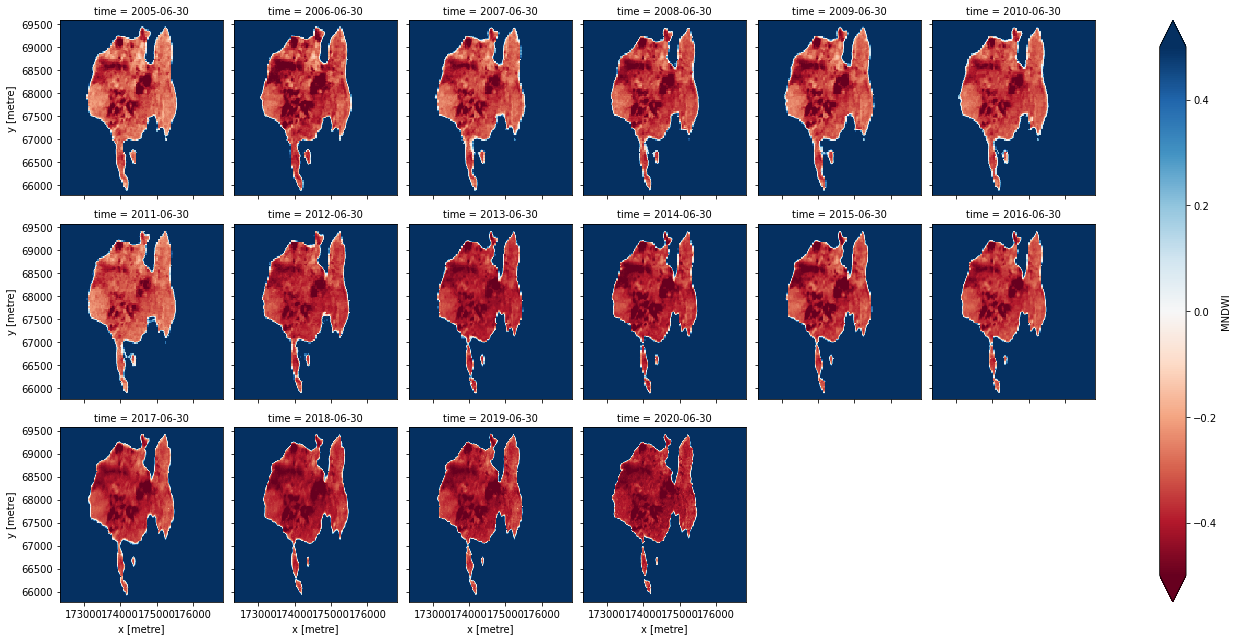

In [11]:
# Combine into summary images by `time_step`
ds_summaries = (ds.MNDWI
                     .compute()
                     .resample(time='1Y', label='left', loffset='6M')
                     .median('time'))

# Plot the output summary images
ds_summaries.plot(col='time',
                       cmap='RdBu',
                       col_wrap=6,
                       vmin=-0.5,
                       vmax=0.5)
plt.show()

Operating in single z-value, multiple arrays mode
Writing contours to output_waterlines.shp


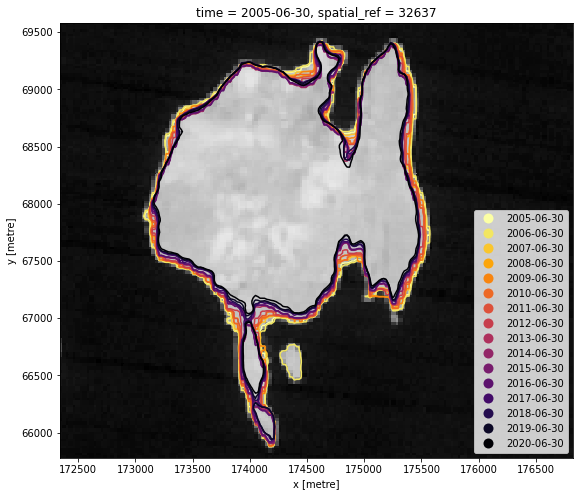

In [12]:
# Set up attributes to assign to each waterline
attribute_data = {'time': [str(i)[0:10] for i in ds_summaries.time.values]}
attribute_dtypes = {'time': 'str'}

# Extract waterline contours for the '0' water index threshold:
contour_gdf = subpixel_contours(da=ds_summaries,
                                 z_values=0,
                                 crs=ds_summaries.geobox.crs,
                                 affine=ds_summaries.geobox.transform,
                                 output_path=f'output_waterlines.shp',
                                 min_vertices=50)

# Plot output shapefile over the first MNDWI layer in the time series
ds_summaries.isel(time=0).plot(size=8, 
                                    cmap='Greys', 
                                    add_colorbar=False)

# add the contours to the plot
contour_gdf.plot(ax=plt.gca(), 
                 column='time', 
                 cmap='inferno_r', 
                 legend=True, 
                 legend_kwds={'loc': 'lower right'})
plt.show()

## annual geomedians

In [13]:
gms_grouped = ds[['red','green', 'blue']].chunk({'time':-1}).resample(time='1Y', label='left', loffset='6M')

In [14]:
gms = gms_grouped.map(xr_geomedian).compute()

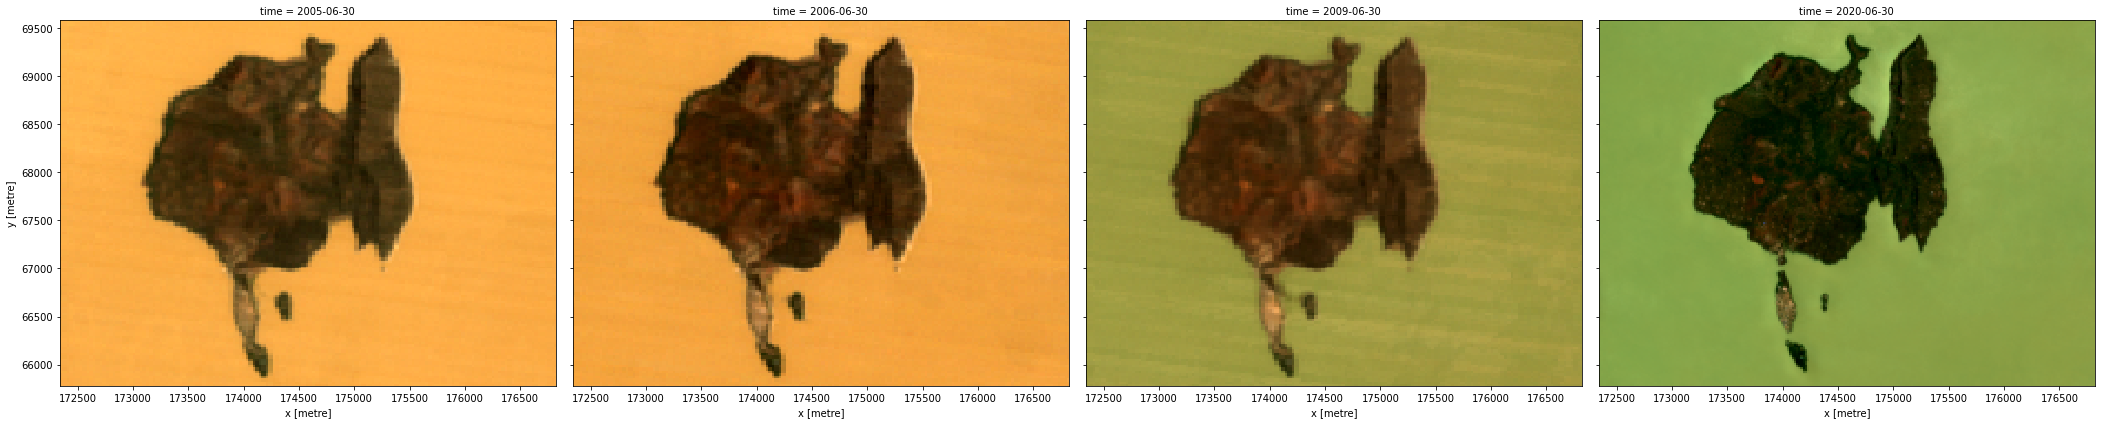

In [15]:
rgb(gms, index=[0,1,4,-1], col_wrap=4)

### RGB animations (mask water?)

In [ ]:
# # Produce time series animation 
# xr_animation(ds=gms.where(ds_summaries<0), 
#              bands=['red', 'green', 'blue'],
#              output_path='rgb_shoreline_change.gif', 
#              interval=600,
#              width_pixels=300)

# # Plot animated gif
# plt.close()
# Image(filename='shoreline_change.gif')

### shoreline change with vector overlay

In [16]:
gdf=gpd.read_file('output_waterlines.shp')

In [17]:
from pylab import *
import matplotlib

cmap = cm.get_cmap('inferno_r', len(gdf)) 
c=[]
for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    color=matplotlib.colors.rgb2hex(rgba)
    c.append(color)

In [18]:
gdf['start_time'] = [str(y) for y in range(2005, 2021)]
# gdf['end_time'] = [str(y) for y in range(2011, 2022)]

# Set vector features to a semi-transperant blue to represent water
gdf['color'] = c#'#FF0000'

# Preview the updated geopandas.GeoDataFrame
gdf.head()

time                                           geometry start_time  \
0  2005-06-30  LINESTRING (174210.012 65890.000, 174210.012 6...       2005   
1  2006-06-30  MULTILINESTRING ((174212.855 65890.000, 174212...       2006   
2  2007-06-30  LINESTRING (174210.113 65890.000, 174210.113 6...       2007   
3  2008-06-30  LINESTRING (174197.797 65890.000, 174197.797 6...       2008   
4  2009-06-30  LINESTRING (174203.399 65890.000, 174203.399 6...       2009   

     color  
0  #fcffa4  
1  #f2e661  
2  #fac62d  
3  #fca50a  
4  #f8850f

In [23]:
gms.where(gms['MNDWI']<0)

<xarray.Dataset>
Dimensions:      (time: 16, x: 224, y: 190)
Coordinates:
  * time         (time) datetime64[ns] 2005-06-30 2006-06-30 ... 2020-06-30
  * y            (y) float64 6.957e+04 6.955e+04 ... 6.581e+04 6.579e+04
  * x            (x) float64 1.724e+05 1.724e+05 ... 1.768e+05 1.768e+05
    spatial_ref  int32 32637
Data variables:
    red          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    green        (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    blue         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    MNDWI        (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan

In [19]:
gms['MNDWI'] = ds_summaries

Exporting animation to greys_shoreline_change.gif


  0%|          | 0/16 (0.0 seconds remaining at ? frames/s)

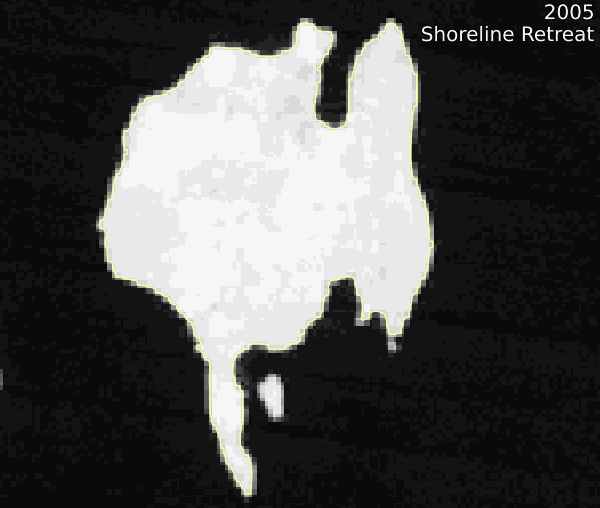

In [53]:
out='greys_shoreline_change.gif'

# Produce time series animation 
xr_animation(ds=gms,#.where(gms['MNDWI']<0), 
             bands='MNDWI',#['red', 'green', 'blue'],
             show_text='Shoreline Retreat',
             output_path=out, 
             show_date='%Y',
             interval=600,
             width_pixels=600,
             show_gdf=gdf,
             show_colorbar=False,
             imshow_kwargs={'cmap': 'Greys'},
             gdf_kwargs={'legend':True, 'legend_kwds':{'loc': 'lower right'}, 'column':'time'}
             ) 
# Plot animated gif
plt.close()
Image(filename=out)

In [58]:
!ffmpeg -i rgb_shoreline_change.mp4 -i legend.PNG -filter_complex "[0:v][0:v] overlay=500:200:enable='between(t,0,40)'" -pix_fmt yuv420p -c:a copy rgb_shoreline_change_legend.mp4

ffmpeg version 4.2.2-static https://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 8 (Debian 8.3.0-6)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gmp --enable-libgme --enable-gray --enable-libaom --enable-libfribidi --enable-libass --enable-libvmaf --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librubberband --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libvorbis --enable-libopus --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libdav1d --enable-libxvid --enable-libzvbi --enable-libzimg
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat   

Exporting animation to rgb.gif


  0%|          | 0/16 (0.0 seconds remaining at ? frames/s)

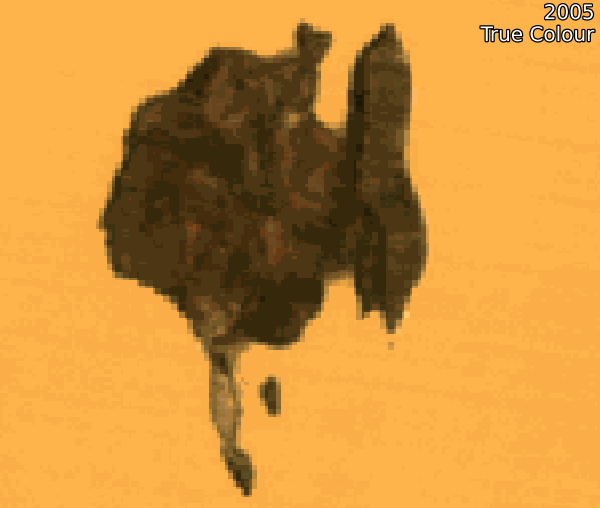

In [57]:
xr_animation(ds=gms,#where(gms['MNDWI']<0), 
             bands=['red', 'green', 'blue'],
             show_text='True Colour',
             output_path='rgb.gif', 
             show_date='%Y',
             interval=600,
             width_pixels=600)
             
# Plot animated gif
plt.close()
Image(filename='rgb.gif')

## interpolate/smooth

In [ ]:
ds = ds.resample(time='1Y', label='left', loffset='6M').median('time')

In [ ]:
ds_mean_3 = ds.rolling(time=3, min_periods=1).mean()
# ds_mean_2 = ds.rolling(time=2, min_periods=1).mean()
# ds_mean_4 = ds.rolling(time=4, min_periods=1).mean()

## Plot time series as a RGB/three band animated GIF


In [ ]:
interval=200
width_pixels=300

In [ ]:
# Produce time series animation of red, green and blue bands
name='rgb_ol_kokwe_2015_2021.gif'

xr_animation(ds=ds_mean_3, 
             bands=['red', 'green', 'blue'],
             show_text='True Colour',
             show_date='%b %Y',
             output_path=name,                                
             interval=interval, 
#              percentile_stretch=(0.05, 0.95),
             width_pixels=width_pixels) 

# Plot animated gif
plt.close()
Image(filename=name)

### MNDWI


In [ ]:
# Produce time series animation of NDWI:
name='MNDWI_ol_kokwe_2015_2021.gif'

xr_animation(ds=ds_mean_3, 
             output_path=name,
             bands=['MNDWI'], 
             show_text='Water (MNDWI)', 
             show_date='%b %Y',
             width_pixels=width_pixels,
             interval=interval,
             imshow_kwargs={'cmap': 'Blues', 'vmin': 0.0, 'vmax': 0.4},
             colorbar_kwargs={'colors': 'black'}
            ) 

# Plot animated gif
plt.close()
Image(filename=name)

### EVI


In [ ]:
# Produce time series animation of NDWI:
name='EVI_ol_kokwe_2015_2021.gif'

xr_animation(ds=ds_mean_3, 
             output_path=name,
             bands=['EVI'],
             show_date='%b %Y',
             show_text='Vegetation (EVI)', 
             width_pixels=width_pixels,
             interval=interval,
             imshow_kwargs={'cmap': 'gist_earth_r', 'vmin': 0., 'vmax': 0.7},
             colorbar_kwargs={'colors': 'black'}
            ) 

# Plot animated gif
plt.close()
Image(filename=name)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** June 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)